In [1]:
from utils import *
import pandas as pd
import datetime as dt

opt_data = pd.read_csv('./data/options.csv')
ibit_data = pd.read_csv('./data/ibit-usd.csv')[["Date", "Adj Close"]]
ibit_data["Date"] = pd.to_datetime(ibit_data["Date"]).dt.tz_localize(None)

opt_data["Expiration_date"] = pd.to_datetime(opt_data["Expiration_date"]).dt.tz_localize(None)
opt_data["lastTradeDate"] = pd.to_datetime(opt_data["lastTradeDate"]).dt.tz_localize(None)

opt_data = opt_data[["contractSymbol", "lastTradeDate", "Expiration_date", "strike", "lastPrice"]]
opt_data["days_to_expiration"] = (opt_data["Expiration_date"] - opt_data['lastTradeDate']).dt.days
opt_data.sort_values(by=["lastTradeDate", "Expiration_date", "strike"], inplace=True)
opt_data

,contractSymbol,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration
83,IBIT250221C00036000,2024-11-19 15:28:56,2025-02-21,36.0,17.70,93
44,IBIT250117C00039000,2024-11-19 15:38:41,2025-01-17,39.0,14.75,58
2,IBIT241220C00037000,2024-11-19 18:49:06,2024-12-20,37.0,17.00,30
181,IBIT260116C00049000,2024-11-19 19:02:40,2026-01-16,49.0,20.50,422
87,IBIT250221C00041000,2024-11-19 19:35:35,2025-02-21,41.0,15.39,93
...,...,...,...,...,...,...
20,IBIT241220C00057000,2024-11-22 20:59:38,2024-12-20,57.0,3.83,27
51,IBIT250117C00046000,2024-11-22 20:59:38,2025-01-17,46.0,12.34,55
23,IBIT241220C00060000,2024-11-22 20:59:43,2024-12-20,60.0,2.71,27
150,IBIT250516C00060000,2024-11-22 20:59:47,2025-05-16,60.0,10.65,174


In [2]:
df = pd.merge_ordered(ibit_data, opt_data, left_on="Date", right_on="lastTradeDate")
df[["Date", "Adj Close"]] = df[["Date", "Adj Close"]].fillna(method="ffill")
df.dropna(subset="contractSymbol", inplace=True)
df = df[["Adj Close", "lastTradeDate", "Expiration_date", "strike", "lastPrice", "days_to_expiration"]].reset_index(drop=True)
df

C:\Users\Andre\AppData\Local\Temp\ipykernel_11920\393537657.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[["Date", "Adj Close"]] = df[["Date", "Adj Close"]].fillna(method="ffill")


,Adj Close,lastTradeDate,Expiration_date,strike,lastPrice,days_to_expiration
0,52.700001,2024-11-19 15:28:56,2025-02-21,36.0,17.70,93.0
1,52.700001,2024-11-19 15:38:41,2025-01-17,39.0,14.75,58.0
2,52.700001,2024-11-19 18:49:06,2024-12-20,37.0,17.00,30.0
3,52.700001,2024-11-19 19:02:40,2026-01-16,49.0,20.50,422.0
4,52.700001,2024-11-19 19:35:35,2025-02-21,41.0,15.39,93.0
...,...,...,...,...,...,...
247,56.490002,2024-11-22 20:59:38,2024-12-20,57.0,3.83,27.0
248,56.490002,2024-11-22 20:59:38,2025-01-17,46.0,12.34,55.0
249,56.490002,2024-11-22 20:59:43,2024-12-20,60.0,2.71,27.0
250,56.490002,2024-11-22 20:59:47,2025-05-16,60.0,10.65,174.0


In [ ]:
mi, sigma, r = pd.read_csv('./data/parameters_ibit.csv').values[0]
mi = 0

df["BS"] = df.apply(lambda x: black_scholes(x["Adj Close"], x["strike"], x["days_to_expiration"], r, sigma), axis=1)

df["Freitas"] = df.apply(lambda x: freitas(x["Adj Close"], x["strike"], x["days_to_expiration"], r, mi, sigma), axis=1)

df["Bachelier"] = df.apply(lambda x: bachelier_option_price(x["Adj Close"], x["strike"], x["days_to_expiration"], sigma, r), axis=1)

df

In [6]:
import pandas as pd

df = pd.read_csv('./data/df_final.csv')
df["lastTradeDate"] = pd.to_datetime(df["lastTradeDate"])
df["Expiration_date"] = pd.to_datetime(df["Expiration_date"])

color_freitas = "#ff66c4"
color_bs = "#7a2be1"
color_real = "#add8e6"
color_background = "black"

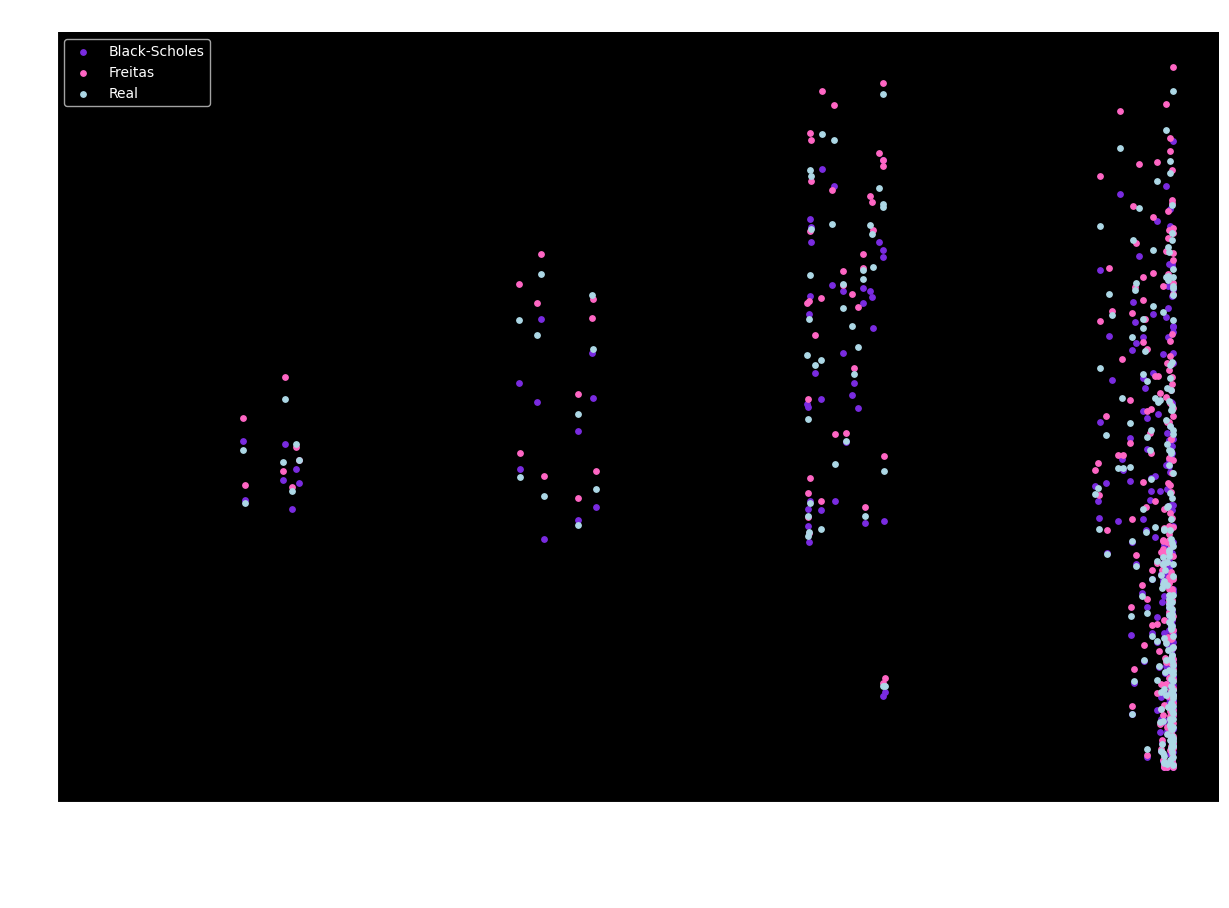

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# tema escuro
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = color_background

plt.scatter(df['lastTradeDate'], df['BS'], label='Black-Scholes', alpha=1, s=15, color=color_bs)
plt.scatter(df['lastTradeDate'], df['Freitas'], label='Freitas', alpha=1, s=15, color=color_freitas)
plt.scatter(df['lastTradeDate'], df['lastPrice'], label='Real', alpha=1, s=15, color=color_real)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Comparação de preços de opções (Black-Scholes vs Freitas vs Real)')

plt.xticks(df["lastTradeDate"].dt.strftime("%Y-%m-%d"), rotation=45)

plt.savefig('./data/images/comparacao_precos.png')

plt.show()

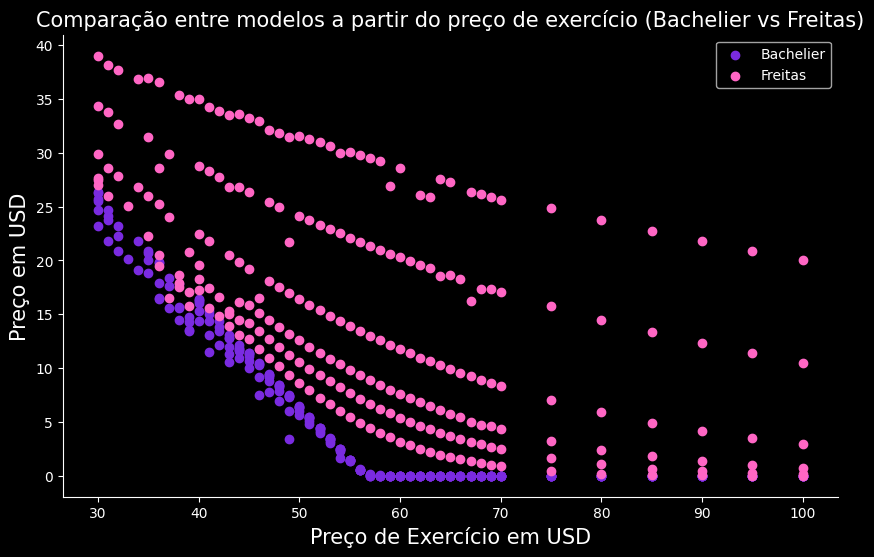

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

xaxis = "strike"

# tema escuro
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = color_background

plt.scatter(df[xaxis], df['Bachelier'], label='Bachelier', color=color_bs)
plt.scatter(df[xaxis], df['Freitas'], label='Freitas', color=color_freitas)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.xlabel('Preço de Exercício em USD', fontsize=15)
plt.ylabel('Preço em USD', fontsize=15)
plt.title('Comparação entre modelos a partir do preço de exercício (Bachelier vs Freitas)', fontsize=15)

plt.savefig('./data/images/comparacao_strike_bachelier.png')

plt.show()

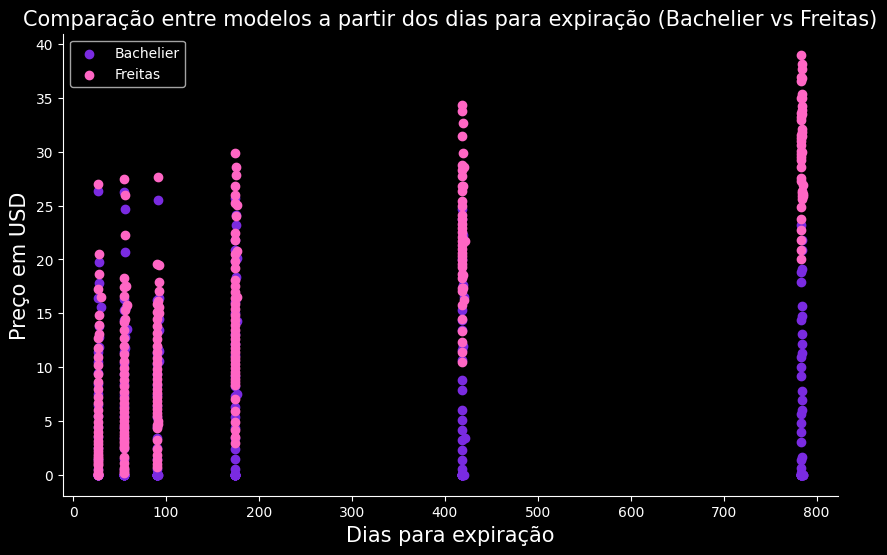

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

xaxis = "days_to_expiration"

# tema escuro
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = color_background

plt.scatter(df[xaxis], df['Bachelier'], label='Bachelier', color=color_bs)
plt.scatter(df[xaxis], df['Freitas'], label='Freitas', color=color_freitas)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.xlabel('Dias para expiração', fontsize=15)
plt.ylabel('Preço em USD', fontsize=15)
plt.title("Comparação entre modelos a partir dos dias para expiração (Bachelier vs Freitas)", fontsize=15)

plt.savefig('./data/images/comparacao_dias_expiracao_bachelier.png')

plt.show()

Correlação:  0.9933151162442265


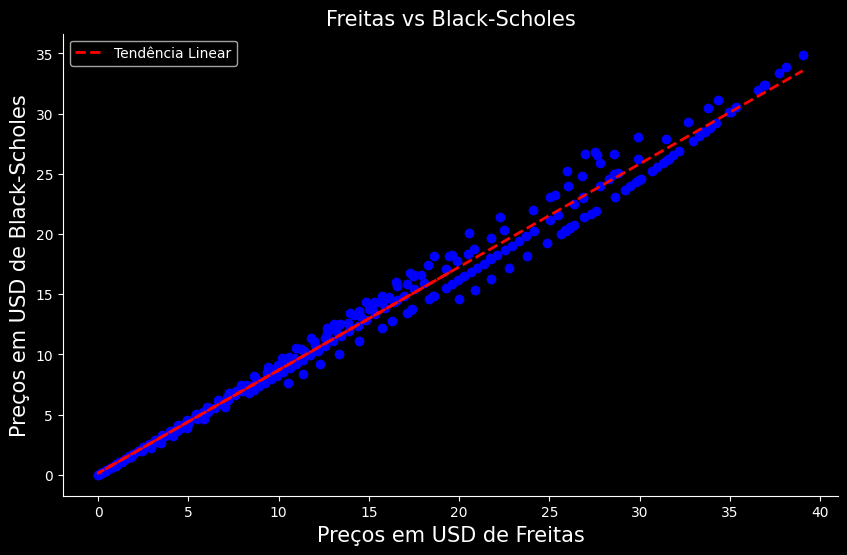

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

xaxis = "days_to_expiration"

# tema escuro
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = color_background

plt.scatter(df["Freitas"], df['BS'], color="blue")

# Reta de regressão
from sklearn.linear_model import LinearRegression

X = df["Freitas"].values.reshape(-1, 1)
y = df["BS"].values

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

plt.plot(X, y_pred, color="red", label="Tendência Linear", linewidth=2, linestyle="--")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Preços em USD de Freitas', fontsize=15)
plt.ylabel('Preços em USD de Black-Scholes', fontsize=15)
plt.title('Freitas vs Black-Scholes', fontsize=15)
plt.legend()

plt.savefig('./data/images/comparacao_freitas_bs.png')

print("Correlação: ", np.corrcoef(df["Freitas"], df["BS"])[0, 1])

plt.show()

In [13]:
df["abs_diff_BS"] = abs(df["BS"] - df["lastPrice"])
df["abs_diff_Freitas"] = abs(df["Freitas"] - df["lastPrice"])
df["abs_diff_Bachelier"] = abs(df["Bachelier"] - df["lastPrice"])

df["abs_diff_freitas_BS"] = abs(df["Freitas"] - df["BS"])

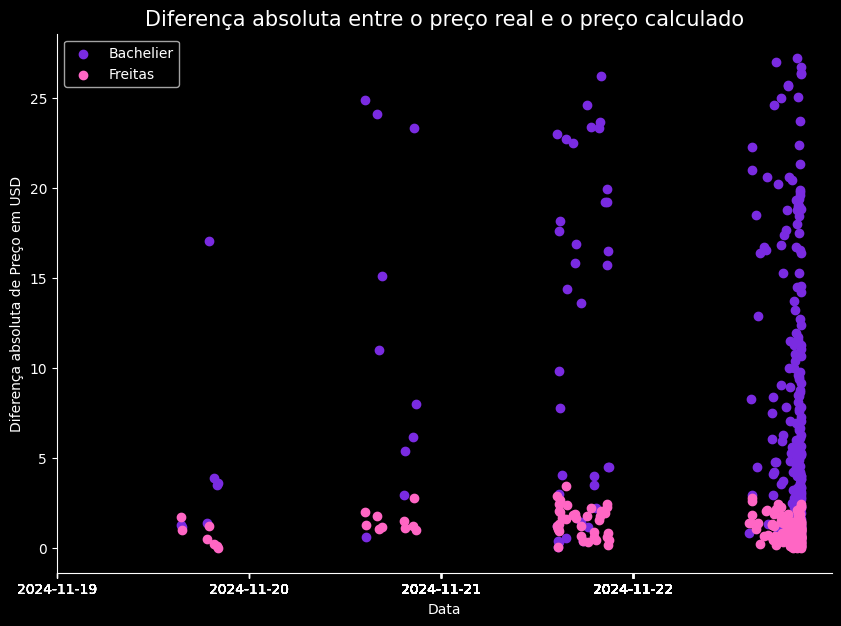

In [14]:
plt.figure(figsize=(10, 7))

plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = color_background

plt.scatter(df["lastTradeDate"], df["abs_diff_Bachelier"], label="Bachelier", color=color_bs)
plt.scatter(df["lastTradeDate"], df["abs_diff_Freitas"], label="Freitas", color=color_freitas)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.xlabel('Data', fontsize=10)
plt.ylabel('Diferença absoluta de Preço em USD', fontsize=10)
plt.title('Diferença absoluta entre o preço real e o preço calculado', fontsize=15)

plt.xticks(df["lastTradeDate"].dt.strftime("%Y-%m-%d"))

plt.savefig('./data/images/diferenca_absoluta_bachelier.png')

plt.show()

In [15]:
df['abs_diff_Bachelier'].mean(), df['abs_diff_Freitas'].mean()

(8.961730954393364, 1.0644669626766403)